In [63]:
%matplotlib inline
from IPython.display import Image

# Introduction

The purpose of this notebook is to take results from MNI space, and superimpose them on a dataset of streamlines from a single subject. This is for illustrative purposes and a temporary solution to the problem of how to display white matter group results in the context of their underlying white matter anatomy (ideally, a "streamline MNI" brain representative of many control subjects would be used, but this also works for a single brain).

In this case, we are transforming group results from a study on elevated AV1451 binding (a tau tracer) in nonfluent/agrammatic variant primary progressive aphasia. The goal is to view these group results showing elevated AV1451 binding in the white matter superimposed on white matter structures in 3D so that patterns along specific anatomically-modeled tracks, as well as the whole-brain streamline dataset, can be visualized.

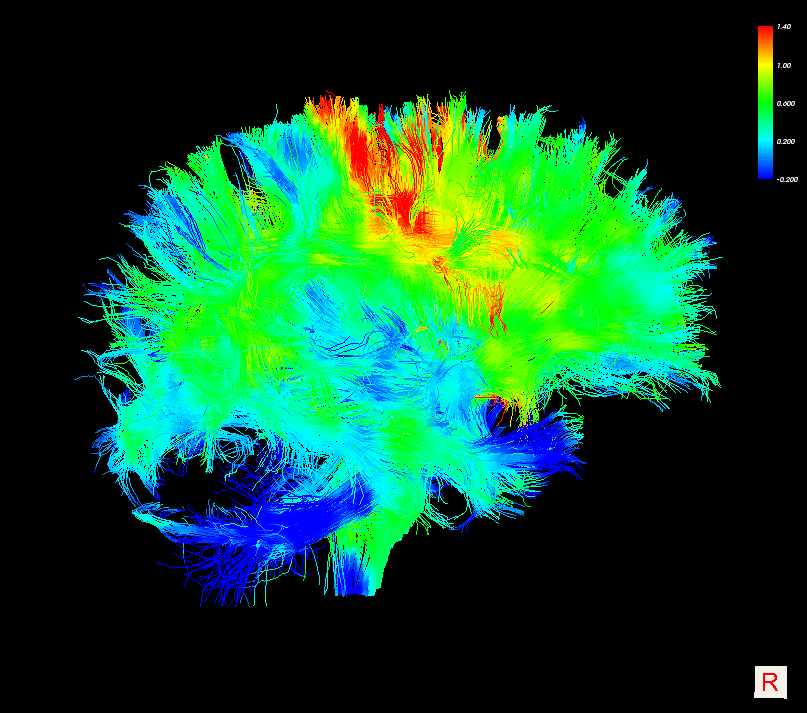

In [105]:
Image("outputs_Superimpose_MNI_Results_on_Tractography/wm_superimpose/sshots/Rb.png")

<img src="outputs_Superimpose_MNI_Results_on_Tractography/wm_superimpose/sshots/Rb.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="outputs_Superimpose_MNI_Results_on_Tractography/wm_superimpose/sshots/Lb.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="outputs_Superimpose_MNI_Results_on_Tractography/wm_superimpose/sshots/aiR.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="outputs_Superimpose_MNI_Results_on_Tractography/wm_superimpose/sshots/aiL.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">


# Import packages

In [54]:
import numpy as np
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

from dipy.align.imaffine import (transform_centers_of_mass, AffineMap, MutualInformationMetric, AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

from nipype.utils.filemanip import load_json
import os
from glob import glob
import nibabel as nib
import scipy.io as sio

from IPython.display import Image
import matplotlib.pyplot as plt

from dipy.io.pickles import save_pickle, load_pickle

import nilearn as nil

# for some reason, these functions aren't found unless imported individually first
from nilearn import plotting
from nilearn.image import resample_to_img

# Functions

Load and save niftis

In [3]:
def loadnii(path):
    im = nib.load(path)
    aff = im.affine
    data = im.get_data()
    return data, aff

In [4]:
def savenii(data, aff, path):
    img = nib.Nifti1Image(data, aff)
    img.get_data_dtype() == np.dtype(np.int16)
    img.set_qform(aff, 1)
    img.set_sform(aff, 1)
    img.to_filename(path)

Binarize an image

In [5]:
def binarize(inpath, outpath):
    check_call(['fslmaths', inpath, '-bin', outpath])

In [6]:
def dilate(inpath, outpath):
    check_call(['fslmaths', inpath, '-dilF', outpath])

In [7]:
def erode(inpath, outpath):
    check_call(['fslmaths', inpath, '-ero', outpath])

In [8]:
def mulimg(path1, path2, outpath):
    check_call(['fslmaths', path1, '-mul', path2, outpath])

Display a registration quality (Red static, Green moving)

In [24]:
def showme(static_im, moving_resampled_im, savebasename=False):
    if savebasename:
        regtools.overlay_slices(static_im, moving_resampled_im, None, 0, "Static", "Moving", savebasename+"_sag.png")
        regtools.overlay_slices(static_im, moving_resampled_im, None, 1, "Static", "Moving", savebasename+"_cor.png")
        regtools.overlay_slices(static_im, moving_resampled_im, None, 2, "Static", "Moving", savebasename+"_ax.png")
    else:
        regtools.overlay_slices(static_im, moving_resampled_im, None, 0, "Static", "Moving")
        regtools.overlay_slices(static_im, moving_resampled_im, None, 1, "Static", "Moving")
        regtools.overlay_slices(static_im, moving_resampled_im, None, 2, "Static", "Moving")

In [11]:
def save_xfmd(orig, reslice_to, mapping, saveaff, savepath):
    '''
    save a transformed image in new space
    
    orig: the image you want to reslice
    reslice_to: image in space you want to save orig in
    mapping: pickled transformation
    saveaff: affine from reslice_to space
    savepath: path you want to save the resliced image to
    '''
    resliced = nil.image.resample_to_img(orig, reslice_to, interpolation='nearest').get_data()
    warped = mapping.transform(resliced)
    savenii(warped, saveaff, savepath)

# Set paths

Set path to the MNI image that will be used to calculate the warp into the "tractography template" space

In [12]:
mnipath_fa = '/usr/local/fsl/data/standard/FMRIB58_FA_1mm.nii.gz'

Set the paths to the image in "tractography template" space

In [13]:
# directory containing all files for the "tractography template" space
basepath = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/'

#what is the basename for saving files related to this registration?
basename = 'mni2prismaHC'

# output directory
outpath = 'outputs_Superimpose_MNI_Results_on_Tractography'
if not os.path.exists(outpath):
    os.mkdir(outpath)

# the whole brain tractography 
wb = os.path.join(basepath,'TRACKs/Whole_Brain_bs_prob.trk')

# the fa image from the diffusion space you want to display results in
fa = glob(os.path.join(basepath, '*EC_fa.nii.gz*'))[0]


load the niftis and specify which image will be static ("tractography template" space) and which image will be moving (MNI space, or the space in which the results are located)

In [14]:
hcfa, hcfa_aff = loadnii(fa)
mnifa, mnifa_aff = loadnii(mnipath_fa)

static=hcfa
moving=mnifa

static_grid2world = hcfa_aff
moving_grid2world = mnifa_aff

# Perform Registration between MNI and "Diffusion Template" Space 

Perform a registration between the MNI space (containing results) and the "diffusion template" space (the space in which you want to display results on streamlines).

## Resample images

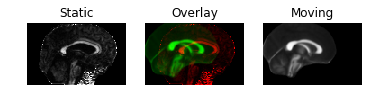

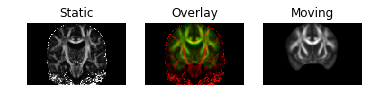

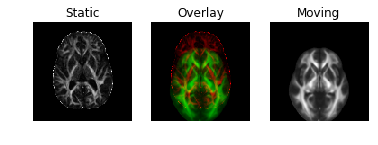

In [28]:
identity = np.eye(4)
affine_map = AffineMap(identity, static.shape, static_grid2world, moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
showme(static, resampled,os.path.join(outpath, basename+'_step0_noxfm'))
#plt.close('all')

## Align the centers of mass

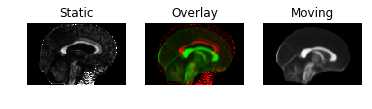

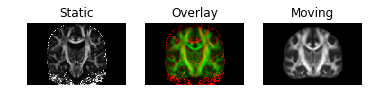

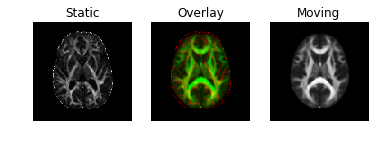

In [29]:
c_of_mass = transform_centers_of_mass(static, static_grid2world, moving, moving_grid2world)
transformed_com = c_of_mass.transform(moving)
showme(static, transformed_com, os.path.join(outpath, basename+'_step1_com'))

## Translation Registration

Optimizing level 2 [max iter: 100000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


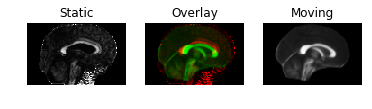

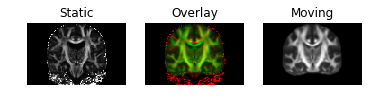

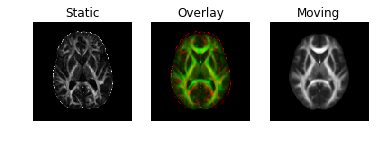

In [30]:
nbins=32
sampling_prop=None
metric=MutualInformationMetric(nbins, sampling_prop)
level_iters = [100000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4,2,1]
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)

transform=TranslationTransform3D()
params0=None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0, static_grid2world, moving_grid2world, starting_affine=starting_affine)
transformed_trans = translation.transform(moving)
showme(static, transformed_trans, os.path.join(outpath, basename+'_step2_trans'))

## Rigid Registration

loading from pkl


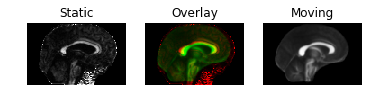

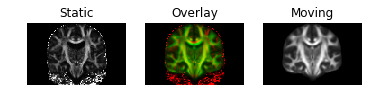

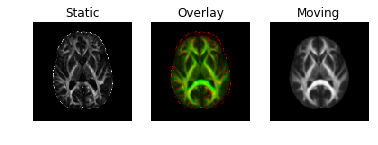

In [35]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine

mypklrigid = os.path.join(outpath, basename+'_step3_rigid.pkl')
if not os.path.exists(mypklrigid):
    rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)
    save_pickle(mypklrigid, rigid)
else:
    print("loading from pkl")
    rigid = load_pickle(mypklrigid)
    
transformed_rigid = rigid.transform(moving)
showme(static, transformed_rigid, os.path.join(outpath, basename+'_step3_rigid'))

savenii(transformed_rigid, static_grid2world, os.path.join(outpath, basename+'_step3_rigid.nii.gz'))


## Affine Registration

Optimizing level 2 [max iter: 100000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


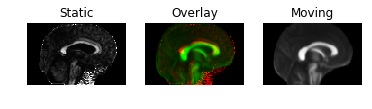

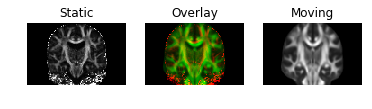

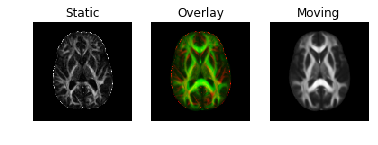

In [39]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine

mypklaff = os.path.join(outpath, basename+'_step4_affine.pkl')
if not os.path.exists(mypklaff):
    affine = affreg.optimize(static, moving, transform, params0,
                             static_grid2world, moving_grid2world,
                             starting_affine=starting_affine)
    save_pickle('prisma_hc_affine.pkl', affine)
else:
    affine = load_pickle(mypklaff)
transformed_affine = affine.transform(moving)
showme(static, transformed_affine, os.path.join(outpath, basename+'_step4_affine'))
savenii(transformed_affine, static_grid2world, os.path.join(outpath, basename+'_step4_affine.nii.gz'))

## Diffeomorphic Registration

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


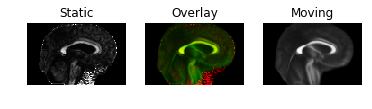

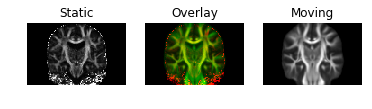

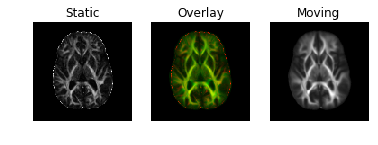

In [45]:
metric=CCMetric(3)
pre_align = affine.affine
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

mypklwarp = os.path.join(outpath, basename+'_step5_warp.pkl')
if not os.path.exists(mypklwarp):
    mapping_fa = sdr.optimize(static, moving, static_grid2world, moving_grid2world, pre_align)
    save_pickle(mypklwarp, mapping_fa)
else:
    mapping_fa = load_pickle(mypklwarp)

warped_moving_fa = mapping_fa.transform(moving)

showme(static, warped_moving_fa, os.path.join(outpath, basename+'_step5_warp'))
savenii(warped_moving_fa, static_grid2world, os.path.join(outpath, basename+'_step5_warp.nii.gz'))

# Now transform results into the "diffusion template" space

In [67]:
#not sure what this was for...
#white_path = '/Users/kesshijordan/ref_data/PET_MNI_MASKS/White_Matter.nii.gz'
#save_xfmd(white_path, mnipath_fa,mapping_fa,static_grid2world, savepath.replace('.nii.gz','_wm.nii.gz'))

Warp the average wmap (mean wscore per voxel) and a 95pct wmap (counts the number of patients with "elevated binding"; this map is not biased by extremely high binding in a few patients) per voxel into diffusion template space

In [70]:
# not sure why this is how I named outputs...
#savepath = wmap_path.replace('.nii.gz', '_prismahc_diffsp.nii.gz')

wmap_path = 'agg_95pct_wmap_masked.nii.gz'

wmap_avg_path = 'agg_wmap.nii.gz'

# Giovanni's blobs that we want to display in with tracks for Marilu's talk
spmblob_path = '/Volumes/macdata/groups/language/kesshi/SPM/kesshi_test/kesh_disconn_masks/disconn/cluster_size_thr100.nii.gz'

# mask provided by PET group (Renaud & Adrienne)
petmask_path = '/Users/kesshijordan/ref_data/PET_MNI_MASKS/mask_sum_GM-WM_sup0p5_without_crblm-pons.nii'
wmap, wmap_aff = loadnii(wmap_path)

wmap_resliced = nil.image.resample_to_img(wmap_path, mnipath_fa, interpolation='nearest').get_data()
spm_resliced = nil.image.resample_to_img(spmblob_path, mnipath_fa, interpolation='nearest').get_data()
petmask_resliced = nil.image.resample_to_img(petmask_path, mnipath_fa, interpolation='nearest').get_data()
wmap_avg_resliced = nil.image.resample_to_img(wmap_avg_path, mnipath_fa, interpolation='nearest').get_data()

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


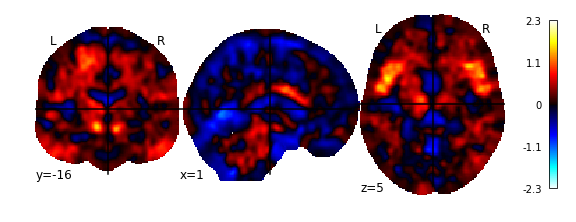

In [65]:
nil.plotting.plot_stat_map(wmap_avg_path)

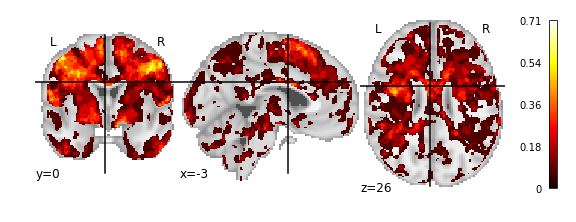

In [56]:
nil.plotting.plot_stat_map(wmap_path)

Warp the resliced maps we want in the diffusion template space, and save them

In [72]:
warpedwmap = mapping_fa.transform(wmap_resliced)
warpedspm = mapping_fa.transform(spm_resliced)
warpedpetmask = mapping_fa.transform(petmask_resliced)
warpedwmapavg = mapping_fa.transform(wmap_avg_resliced)

savebase = os.path.join(outpath, basename)
savenii(warpedwmap, static_grid2world, savebase+'_wmap_95pct.nii.gz')
savenii(warpedspm, static_grid2world, savebase+'_spm_blobs.nii.gz')
savenii(warpedpetmask, static_grid2world, savebase+'_petmask.nii.gz')
savenii(warpedwmapavg, static_grid2world, savebase+'_wmap_avg.nii.gz')

# Merge any tracks that you want displayed together in Trackvis into one file

In [98]:
trk_basepath = os.path.join(basepath,'TRACKs') #this used to also be the putpath
trk_putpath = os.path.join(outpath,'wm_superimpose')
trk_list = glob(trk_basepath+'/*prob.trk')[:3]

In [99]:
from nibabel.streamlines import save as save_trk
def mergeme(trk_list,putpath):
    merged = []
    for track in trk_list:
        trk,hdr = nib.trackvis.read(track)
        sls = [item[0] for item in trk]
        print(len(sls))
        merged += sls
    mergedtrk = [(item, None, None) for item in merged]
    nib.trackvis.write(putpath, mergedtrk, hdr)

In [102]:
mergeme(trk_list[1:], os.path.join(trk_putpath,'merged_ASLANT_ILF.trk'))

2242
11041


In [103]:
mergeme(trk_list, os.path.join(trk_putpath,'merged_wb_ASLANT_ILF.trk'))

6544476
2242
11041
